In [1]:
#Import essential libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [2]:
#Get training data
trainData = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
trainData.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
#Get testing data
testData = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
testData.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [4]:
#Removes stopwords from tweets

"""
stopWords = set(stopwords.words("english")) 

for i in range(len(trainData) + len(testData)):
    if i < len(trainData):
        currWords = list(trainData["text"][i].split(" "))
        trainData["text"][i] = ' '.join([word for word in currWords if not word in stopWords])
    else:
        currWords = list(testData["text"][i - len(trainData)].split(" "))
        testData["text"][i - len(trainData)] = ' '.join([word for word in currWords if word not in stopWords])
"""

'\nstopWords = set(stopwords.words("english")) \n\nfor i in range(len(trainData) + len(testData)):\n    if i < len(trainData):\n        currWords = list(trainData["text"][i].split(" "))\n        trainData["text"][i] = \' \'.join([word for word in currWords if not word in stopWords])\n    else:\n        currWords = list(testData["text"][i - len(trainData)].split(" "))\n        testData["text"][i - len(trainData)] = \' \'.join([word for word in currWords if word not in stopWords])\n'

In [5]:
#Creates text tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words = 30000, filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower = True,
    split = ' ', char_level = False, oov_token = "OOV")

#Fits the tokenizer on the training and testing data
concatText = list(trainData["text"])
concatText.extend(list(testData["text"]))
tokenizer.fit_on_texts(concatText)

#Converting training data to tokenized sequences
trainSequences = tokenizer.texts_to_sequences(trainData["text"])
trainSequences = tf.keras.preprocessing.sequence.pad_sequences(trainSequences, maxlen = 33)
trainLabels = np.array(trainData["target"])

#Converting testing data to tokenized sequences
testSequences = tokenizer.texts_to_sequences(testData["text"])
testSequences = tf.keras.preprocessing.sequence.pad_sequences(testSequences, maxlen = 33)

#Dictionary with all words of tokenizer and their respective indices
word_index = tokenizer.word_index

#Split training data into 9:1 train to val ratio
trainSequences, valSequences, trainLabels, valLabels = train_test_split(trainSequences, trainLabels, test_size = 0.1, random_state = 1)

In [6]:
#Get pretrained multi dimensional glove word embeddings
embeddings_index = {}
f = open("/kaggle/input/glove6b100d/glove.6B.100d.txt")

#Create a matrix with multi dimensional vectors for each word
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype = "float32")
    embeddings_index[word] = coefs
    
f.close()

In [7]:
#Initialize embedding matrix with zeros (words not in glove embeddings index will have zeros)
embedding_matrix = np.zeros((len(word_index) + 1, 100))

#Assign each word in the tokenizer dictionary its respective multi dimensional feature vector
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [8]:
#Create a bidirectional LSTM model (allows for all words to be connected over long sequences)
model = tf.keras.models.Sequential([tf.keras.layers.Embedding(len(word_index) + 1, 100, input_length = 33, trainable = False, weights = [embedding_matrix]),
                        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences = True)),
                        tf.keras.layers.Dropout(0.4),
                        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences = True)),
                        tf.keras.layers.Dropout(0.4),
                        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences = False)),
                        tf.keras.layers.Dropout(0.25),      
                        tf.keras.layers.Dense(1, activation = "sigmoid")
                        ])

In [9]:
#Compile the model (opt is defined as for easy tweaking)
opt = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)

model.compile(optimizer = opt, loss = "binary_crossentropy", metrics = ["acc"])

In [10]:
#Train the model
history = model.fit(trainSequences, trainLabels, epochs = 10, validation_data = (valSequences, valLabels), batch_size = 512)

Epoch 1/10
14/14 [==============================] - 3s 184ms/step - loss: 0.5561 - acc: 0.7190 - val_loss: 0.4753 - val_acc: 0.7848
Epoch 2/10
14/14 [==============================] - 1s 43ms/step - loss: 0.4562 - acc: 0.7949 - val_loss: 0.4769 - val_acc: 0.7953
Epoch 3/10
14/14 [==============================] - 1s 45ms/step - loss: 0.4295 - acc: 0.8075 - val_loss: 0.4660 - val_acc: 0.8045
Epoch 4/10
14/14 [==============================] - 1s 43ms/step - loss: 0.4202 - acc: 0.8123 - val_loss: 0.4615 - val_acc: 0.8018
Epoch 5/10
14/14 [==============================] - 1s 43ms/step - loss: 0.4077 - acc: 0.8184 - val_loss: 0.4645 - val_acc: 0.8110
Epoch 6/10
14/14 [==============================] - 1s 42ms/step - loss: 0.3988 - acc: 0.8231 - val_loss: 0.4665 - val_acc: 0.8071
Epoch 7/10
14/14 [==============================] - 1s 43ms/step - loss: 0.3889 - acc: 0.8281 - val_loss: 0.4654 - val_acc: 0.8110
Epoch 8/10
14/14 [==============================] - 1s 42ms/step - loss: 0.3885 - 

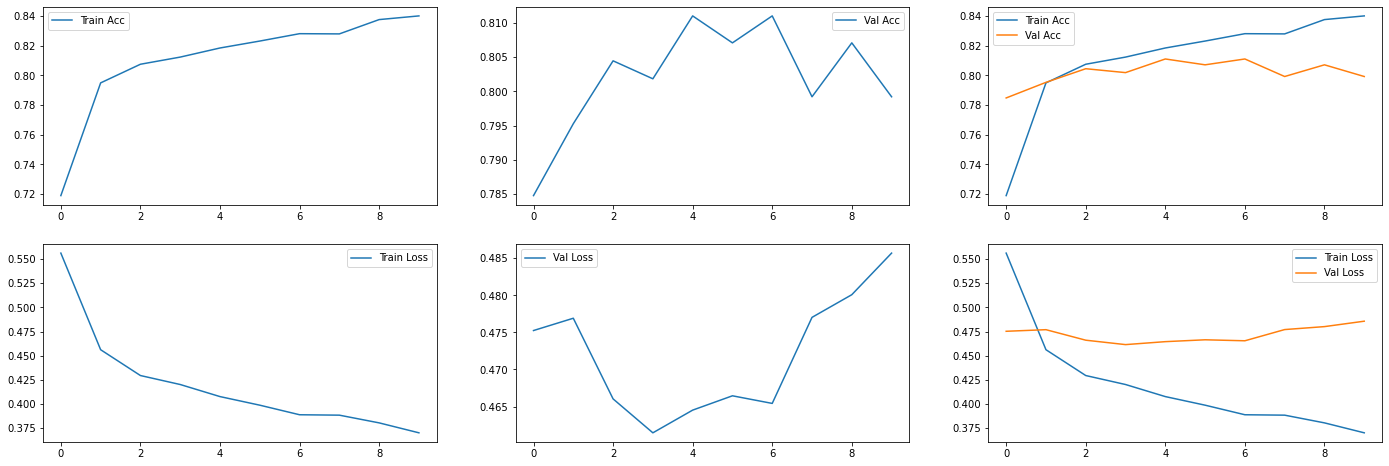

In [15]:
#Plot metrics
plt.rcParams["figure.figsize"] = (24, 8)

plt.subplot(231)

plt.plot(history.history["acc"], label = "Train Acc")
plt.legend()

plt.subplot(232)
plt.plot(history.history["val_acc"], label = "Val Acc")
plt.legend()

plt.subplot(233)
plt.plot(history.history["acc"], label = "Train Acc")
plt.plot(history.history["val_acc"], label = "Val Acc")
plt.legend()

plt.subplot(234)
plt.plot(history.history["loss"], label = "Train Loss")
plt.legend()

plt.subplot(235)
plt.plot(history.history["val_loss"], label = "Val Loss")
plt.legend()

plt.subplot(236)
plt.plot(history.history["loss"], label = "Train Loss")
plt.plot(history.history["val_loss"], label = "Val Loss")
plt.legend()

plt.show()

In [12]:
#Print classification report of predictions on validation data
preds = np.round(model.predict(valSequences))
print(classification_report(valLabels, preds))

              precision    recall  f1-score   support

           0       0.77      0.92      0.84       438
           1       0.86      0.63      0.73       324

    accuracy                           0.80       762
   macro avg       0.82      0.78      0.78       762
weighted avg       0.81      0.80      0.79       762



In [13]:
#Model's predictions on the test data
preds = list(map(int, np.round(model.predict(testSequences))))
submission = pd.DataFrame({"id": testData["id"], "target": preds})
submission.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1


In [14]:
#Convert test predictions data frame to submission csv
submission.to_csv("/kaggle/working/submission.csv", index = False)